In [16]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import matplotlib.pyplot as plt

In [2]:
#python -m spacy download ru_core_news_sm
#import ru_core_news_md
#ru_core_news_md.__version__

In [190]:
#import ru_core_news_md
#lemmatizer = ru_core_news_md.load(disable = ['parser', 'ner'])

In [3]:
import spacy
import re

lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])
stopwords_nltk=[]


#g = re.findall(r'[0-9]+|[A-z]+|,| |"|!', text) с пробелами и знаками препинания

def full_clean(s):
    #подготовка текста к подаче в модель
    s=re.sub(r"[^a-zA-Zа-яА-ЯйЙ#]", " ", s)
    s = s.lower()
    s = re.sub(" +", " ", s) #оставляем только 1 пробел
    text = " ".join([token.lemma_ for token in lemmatizer(s) if token.lemma_ not in stopwords_nltk])
    
    return text

2023-11-11 13:54:13.813565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-11 13:54:13.813591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-11 13:54:13.813606: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 13:54:13.817552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 13:54:14.869641: I tensorflow/compiler/

In [4]:
def tfidf_featuring_(tfidf, df):   
    '''Преобразование текста в мешок слов'''
    X_tfidf = tfidf.transform(df)
    #feature_names = tfidf.get_feature_names_out()
    #X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = feature_names, index = df.index)
    
    return X_tfidf.toarray().tolist()

In [5]:
def tfidf_featuring(tfidf, df):   
    '''Преобразование текста в мешок слов'''
    X_tfidf = tfidf.transform(df)
    feature_names = tfidf.get_feature_names_out()
    X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = feature_names, index = df.index)
    
    return X_tfidf

In [6]:
data = pd.read_csv("train.csv")
data

,№ диалога,emotional,texts,отказ от продуктов,жалобы,просроченная задолженность,мошенничество,утеря/кража карты
0,1,positive,Где информация о вкладе 13% Да Оформить новый ...,0,0,0,0,0
1,2,positive,Свяжите с оператором Оформление нового продукт...,0,0,0,0,0
2,3,positive,Свяжите с оператором Оформление нового продукт...,0,0,0,0,0
3,4,positive,Здравствуйте! Можно ли открыть долгосрочный вк...,0,0,0,0,0
4,5,positive,Добрый день. Я сняла деньги с накопительного с...,0,0,0,0,0
...,...,...,...,...,...,...,...,...
123,124,neutral,Кто может помочь вернуть деньги от мошенников...,0,0,0,1,0
124,125,neutral,Можно ли найти мошенника по номеру банковской ...,0,0,0,1,0
125,126,neutral,Не могу найти карту. Что делать? Что если карт...,0,0,0,0,1
126,127,neutral,Как заблокировать карту? Как перевыпустить кар...,0,0,0,0,1


In [7]:
data['clean'] = data['texts'].apply(lambda x: full_clean(x))

In [8]:
data['target']=data['emotional'].map({'positive':1,  "neutral":0, 'negative':-1})

In [9]:
#тренировка модели token_pattern=r'(?u)\b\w\w+\b'
tfidf = TfidfVectorizer(max_features=2000, max_df = 0.9,
                        #analyzer='char_wb', ngram_range=(3, 5), 
                        analyzer='word', ngram_range=(1, 1), 
                        #token_pattern=r'(?u)\b[а-яА-ЯёЁa-zA-Z][а-яА-ЯёЁa-zA-Z]+\b',
                        #tokenizer=lemmatize,
                        lowercase = True, sublinear_tf=True)
tfidf.fit(data['clean'])

TfidfVectorizer(max_df=0.9, max_features=2000, sublinear_tf=True)

In [10]:
#```Сохранение результатов TfidfVectorizer для веб-приложения
joblib.dump(tfidf, 'tfidf.pkl') 
#Загрузка
#tfidf = joblib.load('tfidf.pkl')``` 

['tfidf.pkl']

In [11]:
# Мешок слов по всем текстам, тренирвочным и тестовым вместе
#X_tfidf = tfidf_featuring(tfidf, data['clean'])
#data['embed']=X_tfidf
#data
X_tfidf = tfidf_featuring(tfidf, data['clean'])
X_tfidf.head()

,cvc,jcb,nan,pay,unilon,union,visa,авто,автокредит,автоматически,...,читаться,чо,что,чтобы,чёрт,шь,это,этот,являться,ясный
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Тональность

In [12]:
X_train_part, X_valid, Y_train_part, Y_valid = train_test_split(X_tfidf, data['target'], 
                                                                test_size=0.20, shuffle = True)

train_pool = Pool(X_train_part, Y_train_part)
test_pool = Pool(X_valid, Y_valid)

In [13]:
clf = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    learning_rate=0.5,
    iterations=500,
    max_depth = 6, 
    #class_names=['отказ от продуктов', 'жалобы', 'просроченная задолженность', 'мошенничество', 'утеря/кража карты']
)
clf.fit(train_pool, eval_set=test_pool, #metric_period=10, plot=True, 
        early_stopping_rounds = 100, use_best_model=True, verbose=100)

0:	learn: 0.5882353	test: 0.3846154	best: 0.3846154 (0)	total: 51.4ms	remaining: 25.6s
100:	learn: 1.0000000	test: 0.7307692	best: 0.8076923 (6)	total: 151ms	remaining: 596ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8076923077
bestIteration = 6

Shrink model to first 7 iterations.


In [151]:
#модель для тональности
clf.save_model('model1.cbm')

In [152]:
valid_predict = clf.predict(X_valid)

In [153]:
t = pd.DataFrame(valid_predict, columns=['predict'], index = list(X_valid.index))
t['target']=t['predict'].map({1:'positive', 0: "neutral", -1:'negative'})
t

,predict,target
21,1,positive
37,1,positive
74,0,neutral
117,-1,negative
106,-1,negative
0,1,positive
46,0,neutral
43,0,neutral
89,-1,negative
11,1,positive


<BarContainer object of 20 artists>

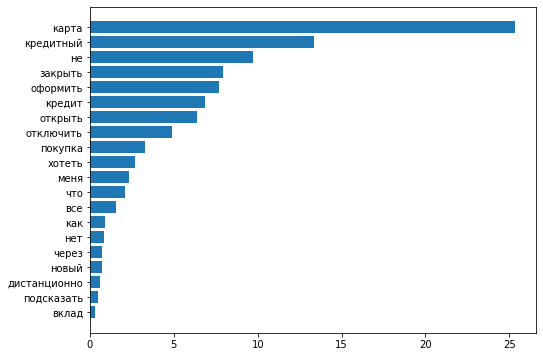

In [17]:
#влияющие факторы
fig, ax = plt.subplots(figsize=(8, 6))
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
ax.barh(fea_imp['col'], fea_imp['imp'], align='center')

Стоп темы

In [119]:
#stop_theme = ['отказ от продуктов', 'жалобы', 'просроченная задолженность', 'мошенничество', 'утеря/кража карты']
#X_train_part, X_valid, Y_train_part, Y_valid = train_test_split(data[['texts']], data[stop_theme], 
#                                                                shuffle = True)

#train_pool = Pool(X_train_part, Y_train_part, text_features=['texts'])
#test_pool = Pool(X_valid, Y_valid, text_features=['texts'])

In [18]:
stop_theme = ['отказ от продуктов', 'жалобы', 'просроченная задолженность', 'мошенничество', 'утеря/кража карты']
X_train_part, X_valid, Y_train_part, Y_valid = train_test_split(X_tfidf, data[stop_theme], 
                                                                test_size=0.25, shuffle = True)

train_pool = Pool(X_train_part, Y_train_part)
test_pool = Pool(X_valid, Y_valid)

In [19]:
clf = CatBoostClassifier(
    loss_function='MultiLogloss',
    eval_metric='Accuracy',
    learning_rate=0.5,
    iterations=500,
    max_depth = 6, 
    class_names=['отказ от продуктов', 'жалобы', 'просроченная задолженность', 'мошенничество', 'утеря/кража карты']
)
clf.fit(train_pool, eval_set=test_pool, #metric_period=10, plot=True, 
        early_stopping_rounds = 100, use_best_model=True, verbose=100)

0:	learn: 0.5833333	test: 0.7187500	best: 0.7187500 (0)	total: 5.48ms	remaining: 2.73s
100:	learn: 1.0000000	test: 0.7812500	best: 0.8125000 (3)	total: 153ms	remaining: 603ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8125
bestIteration = 3

Shrink model to first 4 iterations.


In [20]:
#модель для стоптем
clf.save_model('model2.cbm')

In [21]:
valid_predict = clf.predict(X_valid)

In [22]:
t = pd.DataFrame(valid_predict, columns=stop_theme, index = list(X_valid.index))

In [23]:
t['predict']=t.astype(int).dot(t.columns+',').str[:-1]
t

,отказ от продуктов,жалобы,просроченная задолженность,мошенничество,утеря/кража карты,predict
19,0,0,0,0,0,
38,0,0,0,0,0,
50,0,0,0,0,0,
36,0,0,0,0,0,
8,0,0,0,0,0,
74,0,0,0,0,0,
6,0,0,0,0,0,
109,1,0,0,0,0,отказ от продуктов
12,0,0,0,0,0,
55,0,0,0,0,0,


<BarContainer object of 20 artists>

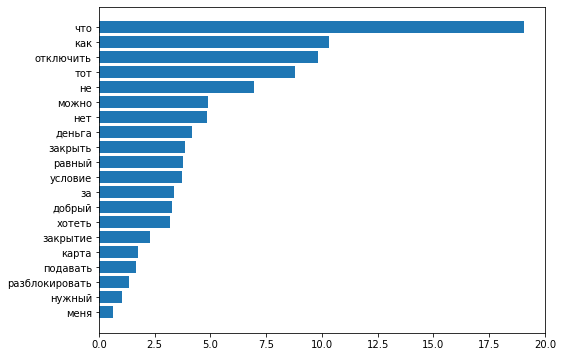

In [24]:
#влияющие факторы
fig, ax = plt.subplots(figsize=(8, 6))
fea_imp = pd.DataFrame({'imp': clf.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
ax.barh(fea_imp['col'], fea_imp['imp'], align='center')

In [23]:
#accuracy_per_class = eval_metric(X_valid, valid_predict, 'Accuracy:type=PerClass')
#for cls, value in zip(clf.classes_, accuracy_per_class):
#    print(f'Accuracy for class {cls}: {value}')

In [25]:
#for metric in ('Precision', 'Recall', 'F1'):
#    print(metric)
#    values = eval_metric(X_valid, valid_predict, metric)
#    for cls, value in zip(clf.classes_, values):
#        print(f'class={cls}: {value:.4f}')
#    print()

In [182]:
def get_params(data, start, emotional):
    # номер диaлога и тональность
    nums=[]
    num = start
    for i, row in data.iterrows():
        if row["№ сообщения"]==1:
            num+=1
        nums.append(num)
    data['№ диалога']=nums
    data['emotional']=emotional
    return data

def create_texts(data):
    # тексты пользователя для датасета
    texts=[]
    string = ''
    for i, row in data.iterrows():
        if row["№ сообщения"]==1:
            if string != '':
                texts.append(string)
                string = str(row["Текст"])+' '
            else:
                string += str(row["Текст"])+' '
        else:
            if row["Направление"]=='in':
                string += str(row["Текст"])+' '
    texts.append(string)
    return texts

def load_file():
    '''Загрузка файла'''
    df = pd.read_excel('LDT_app/data/Газпром_valid.xlsx', sheet_name='valid', engine='openpyxl')
    df = get_params(df, 0, "unknow")
    data = df[['№ диалога', 'emotional']].drop_duplicates()
    data['texts']=create_texts(df)
    data['отказ от продуктов']=0
    data['жалобы']=0
    data['просроченная задолженность']=0
    data['мошенничество']=0
    data['утеря/кража карты']=0
    data['clean'] = data['texts'].apply(lambda x: full_clean(x))
    return data

In [183]:
data=load_file()

In [179]:
data['texts']=create_texts(df)

In [184]:
data

,№ диалога,emotional,texts,отказ от продуктов,жалобы,просроченная задолженность,мошенничество,утеря/кража карты,clean
0,1,unknow,Где информация о вкладе 13% Да Оформить новый ...,0,0,0,0,0,где информация о вклад да оформить новый откры...
13,2,unknow,Добрый день. Я сняла деньги с накопительного с...,0,0,0,0,0,добрый день я снять деньга с накопительный сч ...
43,3,unknow,Обычный накопительный счёт Да Открыть новый Да...,0,0,0,0,0,обычный накопительный сч т да открыть новый да...
61,4,unknow,Хочу оформить вашу кредитную карту. Но официал...,0,0,0,0,0,хотеть оформить ваш кредитный карта но официал...
78,5,unknow,"Здравствуйте, хотел оформить кредит по низкой ...",0,0,0,0,0,здравствовать хотеть оформить кредит по низкий...
90,6,unknow,Не могу перевести деньги с карты другого банка...,0,0,0,0,0,не мочь перевести деньга с карта другого банк ...
112,7,unknow,Забыл пин код от карты Расскажи МИР JCB,0,0,0,0,0,забыть пин код от карта рассказать мир jcb
122,8,unknow,Качество обслуживания ужасное,0,0,0,0,0,качество обслуживание ужасный
124,9,unknow,Вы издеваетесь? Просто самый худший банк!!!!! ...,0,0,0,0,0,вы издеваться просто самый плохой банк газпром...
130,10,unknow,Я задала конкретный ясный вопрос. Зачем пересп...,0,0,0,0,0,я задать конкретный ясный вопрос зачем переспр...
